# Triangle Rasterization

## Import

In [1]:
import numpy as np
import copy
import math 
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  rcParams
import cv2

eps = 1e-6

## Camera Transformation

给定一个相机位置 $\mathbf{eye}$，一个观察点 $\mathbf{center}$，一个上方向 $\mathbf{up}$，可以如下求出相机坐标下的三个右手系正交单位基底：（注意这里相机朝向 $\mathbf{z}_{\text{cam}}$ 的负方向）

$$
\begin{aligned}
\mathbf{z}_{\text{cam}} &= \frac{\mathbf{eye}-\mathbf{center}}{\left \| \mathbf{eye}-\mathbf{center} \right \| }  \\
\mathbf{x}_{\text{cam}} &= \frac{\mathbf{up} \times \mathbf{z}_{\text{cam} }}{\left \| \mathbf{up} \times \mathbf{z}_{\text{cam}} \right \| } \\ 
\mathbf{y}_{\text{cam}} &= \mathbf{z}_{\text{cam}} \times \mathbf{x}_{\text{cam}}
\end{aligned}
$$

于是可以构建如下 Camera Matrix：

$$
M_{\text{cam} } =
\begin{bmatrix}
\mathbf{x}_{\text{cam}} &\mathbf{y}_{\text{cam}}  &\mathbf{z}_{\text{cam}} & \mathbf{eye}\\
0 &0  &0  &1
\end{bmatrix}
$$

对于 $ M_{\text{cam}} $，我们有：
$$
\begin{aligned}
\mathbf{p}_{\text{world}} = M_{\text{cam}} \ \mathbf{p}_{\text{cam}} \\
\mathbf{p}_{\text{cam}} = M_{\text{cam}}^{-1} \ \mathbf{p}_{\text{world}}
\end{aligned}
$$
其中 $\mathbf{p}_{\text{world}}$ 和 $\mathbf{p}_{\text{cam}}$ 分别表示世界坐标系和相机坐标系下的点，使用齐次坐标表示。

In [2]:
def LookAt(eye, center, up):
    """
    构建相机的视图矩阵 M_cam^-1，其中
    eye 表示相机在世界坐标系的位置，
    center 表示相机镜头对准的物体在世界坐标系的位置，
    up 表示相机朝上的方向在世界坐标系中的方向。

    Week03 Lec4 p26
    """
    z = eye - center
    z = z / np.linalg.norm(z)
    x = np.cross(up, z)
    x = x / np.linalg.norm(x)
    y = np.cross(z, x)
    y = y / np.linalg.norm(y)
    cam_mat = np.eye(4)
    cam_mat[:3, 0] = x
    cam_mat[:3, 1] = y
    cam_mat[:3, 2] = z
    cam_mat[:3, 3] = eye
    return np.linalg.inv(cam_mat)

## Projection Transformation

### Orthographic Projection

给定需要进行正交投影的范围 $[\text{left}, \text{right}] \times [\text{bottom}, \text{top}] \times [\text{near}, \text{far}]$，可以构建如下 Orthographic Projection Matrix：

$$
\begin{aligned}
M_{\text{ortho}} &= 
\begin{bmatrix}
\frac{2}{\text{right}-\text{left}} &0  &0  &0 \\
0 &\frac{2}{\text{top}-\text{bottom}}  &0  &0 \\
0 &0  &\frac{2}{\text{near}-\text{far}}  &0 \\
0 &0  &0  &1
\end{bmatrix}
\begin{bmatrix}
1 &0  &0  &-\frac{\text{right}+\text{left}}{2} \\
0 &1  &0  &-\frac{\text{top}+\text{bottom}}{2} \\
0 &0  &1  &-\frac{\text{far}+\text{near}}{2} \\
0 &0  &0  &1
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{2}{\text{right}-\text{left}} &0  &0  &-\frac{\text{right}+\text{left}}{\text{right}-\text{left}} \\
0 &\frac{2}{\text{top}-\text{bottom}}  &0  &-\frac{\text{top}+\text{bottom}}{\text{top}-\text{bottom}} \\
0 &0  &\frac{2}{\text{near}-\text{far}}  &-\frac{\text{far}+\text{near}}{\text{near}-\text{far}} \\
0 &0  &0  &1
\end{bmatrix}
\end{aligned}
$$

即先将目标范围中心平移到原点，再缩放到 $[-1, 1]$，<u>**注意这里缩放时将 $\text{near}$ 缩放至 $z=1$ 将 $\text{far}$ 缩放至 $z=-1$**</u>

于是给定一个点 $\mathbf{p}_{\text{cam}}$，可以得到其在相机坐标系下的正交投影 $\mathbf{p}_{\text{ortho}}$：

$$
\mathbf{p}_{\text{ortho}} = M_{\text{ortho}} \ \mathbf{p}_{\text{cam}}
$$

In [3]:
def Ortho(left, right, bottom, top, near, far): #正交投影
    """
    构建相机的正交投影矩阵，
    正交投影时，视椎体是一个长方体，
    left 和 right 表示长方体的左、右面的坐标值，
    bottom 和 top 表示长方体下、上面的坐标值，
    near 和 far 表示相机到长方体前、后面的距离。 

    Week03 Lec4 p33
    """
    mat = [
        [2 / (right - left), 0, 0, -(right + left) / (right - left)],
        [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
        [0, 0, 2 / (near - far), -(far + near) / (near - far)],
        [0, 0, 0, 1]
    ]
    mat = np.array(mat)
    return mat

### Perspective Projection

给定一个视角 $\text{fov} \ \left ( \text{rad} \right )$，可以如下地构建 Perspective Projection Matrix：

**首先**，根据近平面距离 $\text{near}$ 和远平面距离 $\text{far}$，可以得到将透视锥形压缩为正交透视的矩阵 $M_{\text{persp} \rightarrow \text{ortho}}$：

$$
M_{\text{persp} \rightarrow \text{ortho}} = 
\begin{bmatrix}
\text{near} &0  &0  &0 \\
0 &\text{near}  &0  &0 \\
0 &0  &\text{near}+\text{far}  &-\text{near} \cdot \text{far} \\
0 &0  &1  &0
\end{bmatrix}
$$

这个矩阵使得近平面 $\text{near}$ 上的点不变，远平面 $\text{far}$ 上的点的 $z$ 坐标不变，但 $x$ 和 $y$ 坐标都被压缩为原来的 $\frac{\text{near}}{\text{far}}$ 倍。推导过程见 Week03 Lec4 的 39-46 页。

**然后**，再根据视角 $\text{fov}$ 和近、远平面，以及视角宽高比 $\text{aspect}$ 可以得到目标区域 $[\text{left}, \text{right}] \times [\text{bottom}, \text{top}] \times [\text{near}, \text{far}]$：

$$
\begin{aligned}
\text{bottom} &= -  \left | \text{near} \cdot \tan \frac{\text{fov}}{2} \right | \\
\text{top} &=  \left | \text{near} \cdot \tan \frac{\text{fov}}{2} \right | \\
\text{left} &= \text{near} \cdot \tan \frac{\text{fov}}{2} \cdot \text{aspect}  \\
\text{right} &= - \text{near} \cdot \tan \frac{\text{fov}}{2} \cdot \text{aspect} \\
\end{aligned}
$$

注意这里 $\text{left}$ 为 $\text{near}$ 相对于摄像机坐标系原点方向的左侧，其他同理，所以需要进行如上符号的计算。

**之后**，再通过前述方法，得到将目标区域进行正交投影的矩阵 $M_{\text{ortho}}$。

**最后**，可以得到 Perspective Projection Matrix：

$$
M_{\text{persp}} = M_{\text{ortho}} \ M_{\text{persp} \rightarrow \text{ortho}}
$$

In [4]:
def get_ortho_params(fov, aspect, near):
    """
    根据相机的视野角度和近裁剪面的距离计算相机的正交投影矩阵的参数
    """
    bottom = -abs(near * math.tan(fov / 2))
    top = abs(near * math.tan(fov / 2))
    left = near * math.tan(fov / 2) * aspect
    right = -near * math.tan(fov / 2) * aspect
    return left, right, bottom, top

def Perspective(fov, aspect=1.0, near=-0.1, far=-10.0): # 默认相机向-z轴方向看，near和far为负数
    """
    构建相机的透视投影矩阵，其中
    fov 表示相机视椎体的 y 方向上的视野角度，
    aspect 表示视椎体的宽高比，即
    near 和 far 表示视椎体近、远裁剪面的距离。

    Week03 Lec4 p35
    """
    fov = fov / 180.0 * math.pi
    # M_{persp -> ortho}
    mat = [ 
        [near, 0, 0, 0],
        [0, near, 0, 0],
        [0, 0, near + far, -near * far],
        [0, 0, 1, 0]
    ]
    mat = np.array(mat)
    # M_{persp} = M_{ortho} * M_{persp -> ortho}
    left, right, bottom, top = get_ortho_params(fov, aspect, near)
    mat = Ortho(left, right, bottom, top, near, far) @ mat
    return mat

## Triangle

三角形类中，需要实现以下两个方法：

### rotate_norm

这里要求实现一个方法，将三角形 $ABC$ 绕过自身重心的法向量旋转 $\theta$ 角度。

**首先**，计算三角形重心：

$$
\mathbf{center} = \frac{\mathbf{A} + \mathbf{B} + \mathbf{C}}{3}
$$

**然后**，计算三角形法向量：

$$
\mathbf{norm} = \left ( \mathbf{B} - \mathbf{A} \right ) \times \left ( \mathbf{C} - \mathbf{A} \right )
$$

**最后**，计算旋转矩阵：

旋转矩阵由三个部分组成：将三角形重心平移到原点、绕法向量旋转 $\theta$ 角度、将三角形重心平移回原来的位置。

$$
\begin{aligned}
M_{\text{center} \rightarrow \text{origin}} &=
\begin{bmatrix}
I &-\mathbf{center} \\
\mathbf{0}  &1
\end{bmatrix} \\ \\

M_{\text{rotate}} &=
cos\theta \begin{bmatrix}  1 & 0 & 0\\  0 & 1 & 0\\  0 & 0 &1 \end{bmatrix} + 
(1-cos\theta)\begin{bmatrix}  k_{x} \\  k_{y} \\ k_{z}  \end{bmatrix}\begin{bmatrix}  k_{x} &  k_{y} &k_{y} \end{bmatrix} + 
sin\theta\begin{bmatrix}  0 &  -k_{z}& k_{y}\\ k_{z}  &0  &-k_{x} \\  -k_{y} & k_{x} &0  \end{bmatrix}\\

M_{\text{rotate}}^{homo} &=
\begin{bmatrix}
M_{\text{rotate}} & \mathbf{0} \\
\mathbf{0} &1 \\
\end{bmatrix} \\ \\

M_{\text{origin} \rightarrow \text{center}} &=
\begin{bmatrix}
I  &\mathbf{center} \\
\mathbf{0}  &1
\end{bmatrix} \\
\end{aligned}
$$

其中，绕法向量旋转 $\theta$ 角度的旋转矩阵 $M_{\text{rotate}}$ 通过 Rodrigues 公式计算得到，$k$ 为单位化的法向量 $\mathbf{norm}$。详细可见[维基百科](https://zh.wikipedia.org/wiki/%E7%BD%97%E5%BE%B7%E9%87%8C%E6%A0%BC%E6%97%8B%E8%BD%AC%E5%85%AC%E5%BC%8F) or Week2 Lec3 p49。

代码中，直接使用了 `cv2.Rodrigues` 函数计算旋转矩阵，该函数接收一个三维向量，该向量方向为旋转轴，旋转方向为该向量的右手螺旋方向，长度为旋转角度，返回一个标准旋转矩阵，这里我们需要将其转换为齐次坐标下的矩阵。

**最终**，我们对三角形的齐次坐标矩阵按序左乘上述矩阵即可完成旋转。

### inside

这里要求实现一个方法，判断一个点是否在三角形内部：

有多种方法能够实现这个操作，都比较直观易懂，这里不再作公式推导：
- <u>若已知点在三角形平面内，则可用二维平面上的重心坐标表示发将点P用三角形两边的线性组合表示出来，并通过线性表示系数判断即可（代码中最终使用的方法，速度最快，因为我们是在投影变换后的二维平面中进行判断），并且还可以将重心坐标返回用于后面的**深度测试**与**颜色差值**的计算</u>
- 当点不一定在三角形平面内时
  - 可使用三维空间的重心坐标法表示出P，然后通过线性表示系数是否和为1且均为正判断
  - 或使用点与三角形顶点的向量与边向量作叉积，并判断三个叉积是否同向同号即可（代码中注释部分有实现，但速度较慢）

### Triangle Class:

In [5]:
class Triangle(object): 
    
    def __init__(self):
        self.vertices = np.zeros((3, 3))
        self.normals = np.eye(3)
        self.colors = np.zeros((3,3))
        self.tex_coords = np.zeros((3, 2))
    
    def setVertex(self, ind, x, y, z):
        self.vertices[ind][0] = x
        self.vertices[ind][1] = y
        self.vertices[ind][2] = z
    
    def setColor(self, ind, r, g, b):
        self.colors[ind][0] = r
        self.colors[ind][1] = g
        self.colors[ind][2] = b
    
    def setNormal(self, ind, nx, ny, nz): # x y x
        self.normals[ind][0] = nx
        self.normals[ind][1] = ny
        self.normals[ind][2] = nz
    
    def setTexCoord(self, ind, tx, ty):
        self.tex_coords[ind][0] = tx
        self.tex_coords[ind][1] = ty

    def rotate_norm(self, theta):
        """
        通过三角形三个顶点计算其法线方向，
        然后计算三个顶点绕三角形中心点，轴为法线旋转 theta 度后的新位置，
        并更新self.vertices
        """
        A = self.vertices[0]
        B = self.vertices[1]
        C = self.vertices[2]
        norm = np.cross(B-A, C-A)
        norm = norm / np.linalg.norm(norm)

        center = (A + B + C) / 3.0

        # 旋转矩阵，绕norm轴旋转thea度，使用Rodrigues公式计算
        mat1 = np.eye(4)
        rot_mat = cv2.Rodrigues(norm * theta)[0]
        mat1[:3,:3] = rot_mat
        # 平移，将三角形中心移动到原点
        mat2 = np.eye(4)
        mat2[:3,3] = -center
        # 平移，将三角形中心移动回去
        mat3 = np.eye(4)
        mat3[:3,3] = center
        # 旋转
        self.vertices = ((mat3 @ mat1 @ mat2 @ self.to_homogeneous_coordinates().T).T)[:,:3]

    
    def rotate_mat(self, mat): #mat 3x3
        self.vertices = (mat @ self.vertices.T).T
    
    def get_barycentric_coord(self, x, y, z):
        A = self.vertices[0]
        B = self.vertices[1]
        C = self.vertices[2]
        P = np.array([x, y, z])

        # 重心坐标法： 快
        # 2D
        AB = B - A
        AC = C - A
        AP = P - A
        # 重心坐标 AP = u * A + v * B + w * C
        v = (np.dot(AP, AB) * np.dot(AC, AC) - np.dot(AP, AC) * np.dot(AB, AC)) / (np.dot(AB, AB) * np.dot(AC, AC) - np.dot(AB, AC) * np.dot(AB, AC))
        w = (np.dot(AP, AC) * np.dot(AB, AB) - np.dot(AP, AB) * np.dot(AB, AC)) / (np.dot(AB, AB) * np.dot(AC, AC) - np.dot(AB, AC) * np.dot(AB, AC))
        u = 1 - v - w
        return u, v, w

        # or 3D
        # 重心坐标 AP = u * A + v * B + w * C

    
    def inside(self, x, y, z):
        """
        判断点(x,y,z)是否在三角形里
        """
        u, v, w = self.get_barycentric_coord(x, y, z)
        if u >= -eps and v >= -eps and w >= -eps:
            return True, u, v, w
        else:
            return False, u, v, w
        
        # 叉乘同向法： 慢
        # AB = B - A
        # BC = C - B
        # CA = A - C
        # AP = P - A
        # BP = P - B
        # CP = P - C
        # c1 = np.cross(AB, AP)
        # c2 = np.cross(BC, BP)
        # c3 = np.cross(CA, CP)
        # if np.dot(c1, c2) >= 0 and np.dot(c2, c3) >= 0 and np.dot(c3, c1) >= 0: # 准确来说，这里还需要判断平行
        #     return True
        # else:
        #     return False
        
    def to_homogeneous_coordinates(self):
        return np.hstack((self.vertices, np.ones((3, 1))))

## Rasterization

光栅化部分，主要要求我们渲染时对三角形颜色进行重心坐标插值，并实现深度测试。

首先，我们已经在三角形部分实现了二维平面上的重心坐标计算，但在光栅化时，我们获得的是已经变换至屏幕空间的三角形，直接使用这个三角形进行重心坐标的计算并进行插值是不正确的，例如从网上寻找的下图：

![透视矫正插值](https://pic1.zhimg.com/80/v2-870848b15ece69ce4801c187ab39df20_1440w.webp)

图中BC两点的“中点”应该是所画红绿蓝线的交点，而在第二幅图中的屏幕空间内取中点则会偏离，这是透视变换导致的问题。解决上述问题的暴力途径是进行逆变换获取渲染的目标点在原相机坐标系下的位置，但这样做显然成本过高。所以我们需要对其进行透视变换矫正插值，来通过变换后的三角形的重心坐标，和三个角的属性值，来获得原空间内三角形的插值结果。

### 透视变换矫正插值

下面主要会给出<u>***透视变换矫正插值***</u>的推导：

</br></br>

首先我们计算待渲染点在原始相机坐标系下的 Z 坐标，以完成<u>**深度测试**</u>，并辅助其他属性的重心坐标差值和透视变换矫正插值：

我们设相机坐标系下三角形三个点分别为：$A, B, C$，其对应投影变换后的屏幕空间内三角形的三个点分别为：$A', B', C'$，

再设待渲染的屏幕空间内的目标点为 $P'$，其屏幕空间内三角形的重心坐标为 $\alpha', \beta', \gamma'$，
其对应的相机坐标系中的原始点为 $P$，其重心坐标为 $\alpha, \beta, \gamma$

由三角形重心插值我们可得到：

$$
\begin{aligned}
Z  &= \alpha Z_A+\beta Z_B + \gamma Z_C \\
Z' &= \alpha' Z_{A'}+\beta' Z_{B'} + \gamma' Z_{C'} \\
\end{aligned}
$$

又因为 $ \alpha' +\beta' + \gamma' =1 $，于是变形得到：

$$
\begin{aligned}
1 &= \alpha' +\beta' + \gamma'  \\
 \frac{Z}{Z} &= \frac{Z_A}{Z_A}\alpha' +\frac{Z_B}{Z_B}\beta' + \frac{Z_C}{Z_C}\gamma'  \\
 Z &= (\frac{Z}{Z_A}\alpha')Z_A +(\frac{Z}{Z_B}\beta')Z_B + (\frac{Z}{Z_C}\gamma')Z_C  \\
\end{aligned}
$$

结合上式，我们可以得出：

$$
(\frac{Z}{Z_A}\alpha') = \alpha，(\frac{Z}{Z_B}\beta')=\beta，(\frac{Z}{Z_C}\gamma')=\gamma  \\
$$

所以

$$
1 = \frac{Z}{Z_A}\alpha'+\frac{Z}{Z_B}\beta'+\frac{Z}{Z_C}\gamma' \\
$$

于是

$$
\frac{1}{Z} = \frac{1}{Z_A}\alpha'+\frac{1}{Z_B}\beta'+\frac{1}{Z_C}\gamma' \\
$$

至此，我们可以计算出 $P$ 在相机坐标系下的 Z 坐标，以完成深度测试。

但细心点可以发现，这里所有 $\mathbf{z}$ 坐标均在分母，所以当三角形有一个顶点以上位于相机平面时，会出现除零错误，这是一个待解决的问题，但只要保证三角形在摄像机前方就不会出现这个错误。

</br></br>

置于<u>**其他属性的差值**</u>，理论上可以直接替换 $\mathbf{z}$，但是由于除零问题的存在，我们需要在得到了 $\mathbf{z}$ 的插值结果后进行式子的变换来规避。对于三个顶点的属性 $I_A,I_B,I_C$，我们有如下关系：

$$
I=\alpha I_A+\beta I_B+\gamma I_C \\
$$

结合上方推导我们有：

$$
I=(\frac{Z}{Z_A}\alpha') I_A+(\frac{Z}{Z_B}\beta') I_B+(\frac{Z}{Z_C}\gamma') I_C \\
$$

于是最终可以得到：

$$
I=(\frac{\alpha'}{Z_A} I_A+\frac{\beta'}{Z_B} I_B+\frac{\gamma'}{Z_C} I_C)Z  \\
$$

至此，我们便可以相对容易的完成透视变换矫正插值，得到正确的深度信息与属性的重心坐标插值结果。

光栅化详细的实现步骤，已经在注释中给出，并且也提出了一些未解决的问题，例如目前不能保证当三角形有顶点位于摄像机坐标系 $\mathbf{z_p} \leq 0$ 时，渲染结果的正确性，尤其是除0问题的存在（两个！！！位置给出）。

In [6]:
class Rasterization(object):

    def __init__(self, width, height, near=-0.1, far=-10.0):

        self.color_buf = np.zeros((height, width, 3)) # color_buf 用于存储对应像素点的最终颜色
        self.z_buf = np.ones((height, width)) * -np.inf # z_buf 用于深度测试，默认值为-inf

        self.view_m = np.eye(4) #视图矩阵
        self.proj_m = np.eye(4) #投影矩阵

        self.near = near
        self.far = far

    def setViewM(self, mat):
        self.view_m = mat

    def setProjM(self, mat):
        self.proj_m = mat
    
    def rasterize_triangle(self, t): #光栅化一个三角形

        H, W, _ = self.color_buf.shape

        # 将三角形顶点转换为齐次坐标
        homo_vertexes_world = t.to_homogeneous_coordinates()
        # 计算坐标系变换和投影变换后三角形顶点的齐次坐标
        homo_vertexes_screen = (self.proj_m @ self.view_m @ homo_vertexes_world.T).T
        homo_vertexes_screen = homo_vertexes_screen / np.repeat(homo_vertexes_screen[:,3:], 4, axis=1) # ！！！已知当三角形顶点在相机平面上或后面时，存在/0问题，需要进行裁剪
        homo_vertexes_screen = homo_vertexes_screen * 0.5 + 0.5  # 归一化到[0,1]

        # 计算仅进行坐标系变换后三角形在摄像机坐标系下的坐标
        homo_vertexes_cam = (self.view_m @ homo_vertexes_world.T).T
        za, zb, zc = homo_vertexes_cam[:,2] # ！！！已知当三角形顶点在相机平面上或后面时，存在/0问题，需要进行裁剪
        ca, cb, cc = t.colors

        # 生成屏幕空间内待渲染的三角形
        raster_t = Triangle()
        raster_t.setVertex(0, homo_vertexes_screen[0][0]*W, homo_vertexes_screen[0][1]*H, 0)
        raster_t.setVertex(1, homo_vertexes_screen[1][0]*W, homo_vertexes_screen[1][1]*H, 0)
        raster_t.setVertex(2, homo_vertexes_screen[2][0]*W, homo_vertexes_screen[2][1]*H, 0)
        A = raster_t.vertices[0]
        B = raster_t.vertices[1]
        C = raster_t.vertices[2]
        AB = B - A
        AC = C - A

        # 光栅化，逐个像素点进行渲染
        for x in range(W):
            for y in range(H):
                is_inside, u, v, w= raster_t.inside(x, H-1-y, 0) # 判断待渲染点是否在三角形内，并获取重心坐标
                if is_inside:
                    # 这里需要进行透视变换矫正差值，计算相机坐标系下对应点的 z 值
                    z = 1/(u/za + v/zb + w/zc)

                    # 一般裁剪，目前无法解决/0的问题
                    if z > self.near or z < self.far:
                        continue

                    # 深度测试，更新 z-buffer
                    if z > self.z_buf[y][x]:
                        self.z_buf[y][x] = z
                        # 重心坐标颜色插值，同样需要进行透视变换矫正差值
                        self.color_buf[y][x] = (u/za * ca + v/zb * cb + w/zc * cc)*z
    
    def get_rgb_img(self):
        return (self.color_buf * 255).astype(np.uint8)
    
    def clear(self):
        self.color_buf = np.zeros_like(self.color_buf)
        self.z_buf = np.ones_like(self.z_buf) * -np.inf
    
    def render(self, t_list): #渲染，输入一个三角形的list
        for t in t_list:
            self.rasterize_triangle(t)

## Tasks

In [7]:
def show_images(images: list, titles: list, n: int, m: int, font_scale: float = 1, dpi: int = 800, tick_step: int = 32):

    plt.figure(dpi=dpi)
    rcParams['font.size'] = 12 * font_scale
    rcParams['font.family'] = 'Times New Roman'
    # 标题大小
    rcParams['axes.titlesize'] = 18 * font_scale
    rcParams['axes.titleweight'] = 'bold'
    # 标题与图形间距
    rcParams['axes.titlepad'] = 20 * font_scale
    # 标尺线宽度
    rcParams['xtick.major.width'] = 1 * font_scale
    rcParams['ytick.major.width'] = 1 * font_scale
    # 标尺线长度
    rcParams['xtick.major.size'] = 4 * font_scale
    rcParams['ytick.major.size'] = 4 * font_scale
    # 标尺与文字间距
    rcParams['xtick.major.pad'] = 4 * font_scale
    rcParams['ytick.major.pad'] = 4 * font_scale
    # 子图间距
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    
    for i in range(n):
        for j in range(m):
            ax = plt.subplot(n, m, i * m + j + 1)
            ax.imshow(images[i * m + j], cmap='gray')
            ax.set_title(titles[i * m + j])
            
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_major_locator(plt.MultipleLocator(tick_step))
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_major_locator(plt.MultipleLocator(tick_step))
    
    plt.show()

### a-d 题

In [8]:
t = Triangle()
t.setVertex(0, 0.0, 1.0, 0.0)
t.setVertex(1,-1.0, 0.0, 1.0)
t.setVertex(2, 1.0, 0.0, 1.0)

t.setColor(0, 1.0, 0.0, 0.0)
t.setColor(1, 0.0, 1.0, 0.0)
t.setColor(2, 0.0, 0.0, 1.0)

> **题目**

对以上三角形进行以下渲染：

a）透视投影图像

b）正交投影图像

c）三角形绕其自身中点旋转 45,90,135,180 度后的透视投影图像

d）颜色插值：根据 Line 119-121 对三角形三个顶点的颜色进行设置，光栅化时，对于三角形里的每个点需根据重心坐标进行颜色插值。

其中，a～c的结果已在下方给出，d（颜色差值）的详细实现方式已经在上方的`Triangle`和`Rasterization`类的描述中给出，这里不再赘述，并且直接在下方所有代码中启用，若无需差值可设置三个点的颜色为同一颜色。

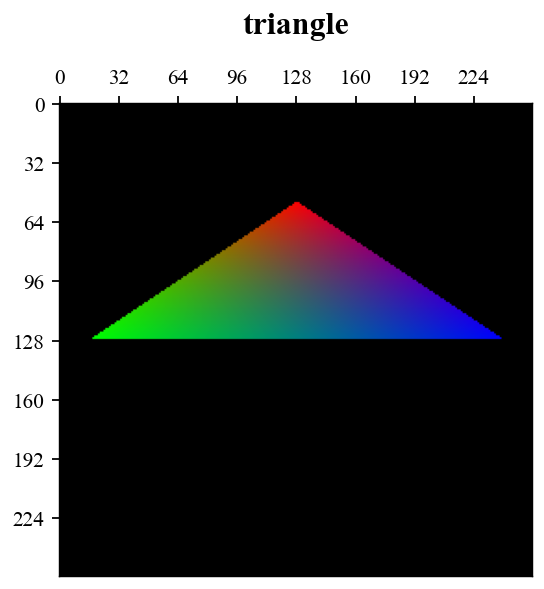

In [9]:
# 透视投影图像渲染

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))

R.render([t])

show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

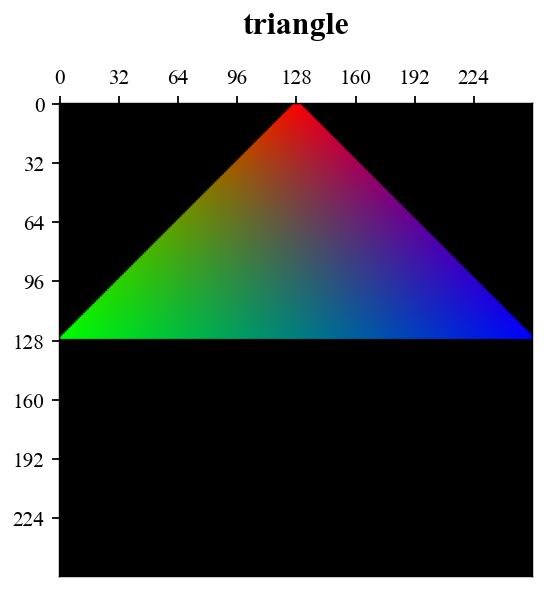

In [10]:
# 正交投影图像渲染

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Ortho(-1, 1, -1, 1, 0.1, 10))

R.render([t])

show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

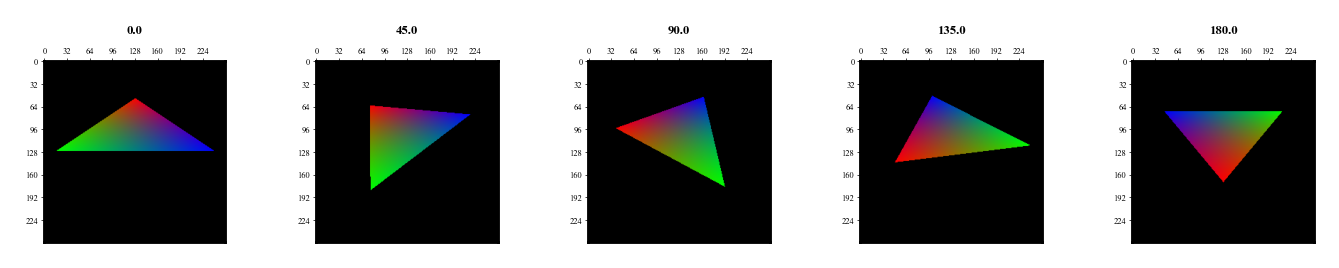

In [11]:
# 三角形绕其自身中点旋转 45,90,135,180 度后的透视投影图像
R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))

theta_step = math.pi / 4 # 旋转步长
steps = 4 # 旋转次数

img = []

R.clear()
R.render([t])
img.append(R.get_rgb_img())
for _ in range(steps):
    R.clear()
    t.rotate_norm(theta_step)
    R.render([t])
    img.append(R.get_rgb_img())

show_images(images=img,
            titles=[f"{(i)*theta_step*180/math.pi:.4}" for i in range(steps+1)],
            n=1,
            m=steps+1,
            font_scale=0.2,
            dpi=256)

### e题

> 题目

深度测试：给定三角形 T1 和 T2，

T1 三个点的坐标为[(0,2,0), (-2, 0, 0), (0,0,0)]，

T2 三个点的坐标为[(-0.5,0.5,0.5),(1.5, 0, 0.5),(2.0, 1.0, 0.5)]，

T1 为红色，T2 为绿色，渲染时考虑深度测试。

此题需要实现深度测试，即当三角形的某个像素点的深度小于已经渲染的像素点的深度时，不进行渲染。

深度测试主要实现方式为使用 z-buffer 存储当前像素已渲染的最浅深度，每次渲染时，判断当前像素的深度是否小于 z-buffer 中的深度（离镜头的距离），若离镜头更近，则进行渲染，并更新 z-buffer。

详细实现步骤已在 `Rassterization` 类中给出描述。

例如下方的三角形深度渲染可以给出正确的前后关系：

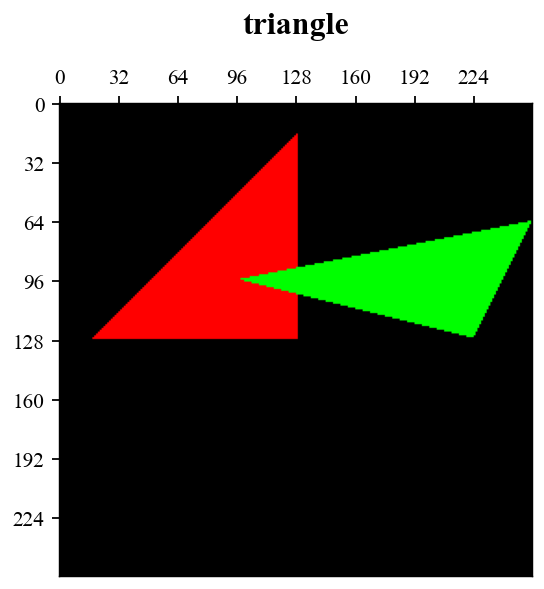

In [12]:
t1 = Triangle()
t1.setVertex(0, 0.0, 2.0, 0.0)
t1.setVertex(1,-2.0, 0.0, 0.0)
t1.setVertex(2, 0.0, 0.0, 0.0)
t1.setColor(0, 1.0, 0.0, 0.0)
t1.setColor(1, 1.0, 0.0, 0.0)
t1.setColor(2, 1.0, 0.0, 0.0)

t2 = Triangle()
t2.setVertex(0,-0.5, 0.5, 0.5)
t2.setVertex(1, 1.5, 0.0, 0.5)
t2.setVertex(2, 2.0, 1.0, 0.5)
t2.setColor(0, 0.0, 1.0, 0.0)
t2.setColor(1, 0.0, 1.0, 0.0)
t2.setColor(2, 0.0, 1.0, 0.0)

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 4]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))
R.render([t1,t2])

# Image.fromarray((R.color_buf*255).astype("uint8")).show()#.save('triangle.jpg')
show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

更改三角形使其中一个三角形穿过另一个三角形，也能正确渲染出深度信息：

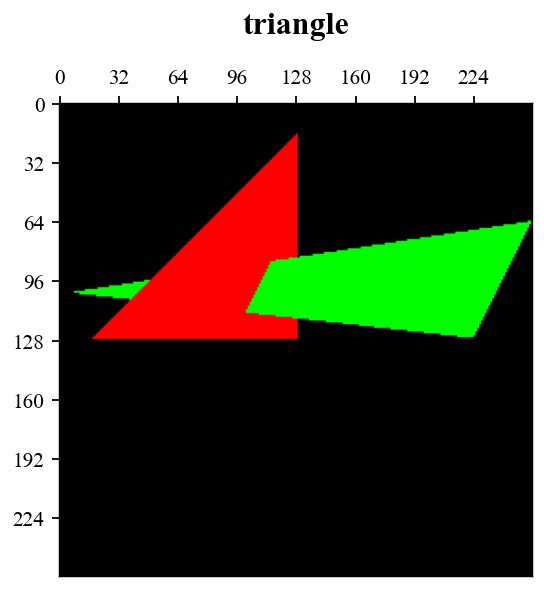

In [13]:
t2 = Triangle()
t2.setVertex(0,-2.5, 0.5, -0.5)
t2.setVertex(1, 1.5, 0.0, 0.5)
t2.setVertex(2, 2.0, 1.0, 0.5)
t2.setColor(0, 0.0, 1.0, 0.0)
t2.setColor(1, 0.0, 1.0, 0.0)
t2.setColor(2, 0.0, 1.0, 0.0)

R.clear()
R.render([t1,t2])

# Image.fromarray((R.color_buf*255).astype("uint8")).show()#.save('triangle.jpg')
show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

### f 题

> 题目

旋转插值：给定三角形 T，

初始状态（t=0）三个顶点的坐标为[(0,0,0),(2,0,0),(1,1,0)], 颜色为红色，

终止状态(t=1)，颜色为绿色，绕坐标轴原点旋转了𝑅 = 𝑅𝑧(60)𝑅𝑦(90)𝑅𝑥(60)。

请渲染出 t=0,0.25,0.5,0.75,1 时刻的图像，注意这里颜色也需要进行插值

此题主要需要实现旋转插值，即球面线性插值（Slerp），下面给出详细实现步骤：

#### Slerp插值

Slerp插值的主要过程为：
- 将旋转矩阵转换为四元数表示
- 对四元数进行 Slerp 插值
  - 计算两个四元数的夹角
  - 计算插值比例
  - 对夹角进行线性插值
- 将插值后的四元数转换为旋转矩阵

整个过程可以通过类比“对表示平面旋转的复数进行插值”来理解。

以下给出了实现步骤，其中使用 Scipy 来实现旋转矩阵与四元数的转化，并给出两种实现，一种自行进行四元数夹角的插值计算，一种使用 Scipy 提供的 `slerp` 函数进行插值计算。其实现方式均为上面步骤给出，仅仅是封装后更便于使用。

In [14]:
# Slerp插值(使用四元数夹角进行插值)
# from scipy.spatial.transform import Rotation
# def slerp(R1, R2, t):
#     # 将旋转矩阵转换为四元数
#     quaternion1 = Rotation.from_matrix(R1).as_quat()
#     quaternion2 = Rotation.from_matrix(R2).as_quat()
    
#     # 计算两个四元数之间的夹角
#     dot_product = np.dot(quaternion1, quaternion2)
#     theta = np.arccos(np.clip(dot_product, -1.0, 1.0))
    
#     # SLERP插值
#     sin_theta = np.sin(theta)
#     s1 = np.sin((1.0 - t) * theta) / sin_theta
#     s2 = np.sin(t * theta) / sin_theta
#     interpolated_quaternion = s1 * quaternion1 + s2 * quaternion2
    
#     # 将插值得到的四元数转换回旋转矩阵
#     interpolated_rotation = Rotation.from_quat(interpolated_quaternion).as_matrix()
    
#     return interpolated_rotation

# Slerp插值(使用scipy)
from scipy.spatial.transform import Rotation, Slerp
def slerp(R1, R2, key_times):
    # 将旋转矩阵转换为四元数
    quaternion1 = Rotation.from_matrix(R1).as_quat()
    quaternion2 = Rotation.from_matrix(R2).as_quat()

    # 创建 Slerp 对象
    slerp_obj = Slerp([0, 1], Rotation.from_quat([quaternion1, quaternion2]))

    # 进行插值
    interpolated_rotations = slerp_obj(key_times)

    # 将插值得到的四元数转换回旋转矩阵
    interpolated_matrices = [item.as_matrix() for item in interpolated_rotations]

    return interpolated_matrices


# interpolated_matrices

#### Lerp插值

这部分为简单的线性插值，用于对颜色相对于时间的变化进行插值

In [15]:
# Lerp
def lerp(c0, c1, key_times):
    return [c0 * (1 - t) + c1 * t for t in key_times]

#### 插值计算

值得注意的是，题目所给的旋转矩阵出现了课堂所讲的 Gimbal Lock 现象，使得最终的旋转从结果上被限制在了一个平面内的方向上（这里是x-z平面）

In [16]:
key_times = [0, 0.25, 0.5, 0.75, 1] # 需要插值的关键帧时间点

# 起始与终止状态旋转矩阵
R0 = np.eye(3)
R1 = np.eye(3)
R1 = cv2.Rodrigues(np.array([1, 0, 0]) * math.pi/3)[0] @ R1
R1 = cv2.Rodrigues(np.array([0, 1, 0]) * math.pi/2)[0] @ R1 # 这里出现了课堂所讲的 Gimbal Lock 
R1 = cv2.Rodrigues(np.array([0, 0, 1]) * math.pi/3)[0] @ R1

# 起始与终止状态颜色
C0 = np.array([1, 0, 0])
C1 = np.array([0, 1, 0])

# 进行插值
interpolated_matrices = slerp(R0, R1, key_times)
interpolated_colors = lerp(C0, C1, key_times)

#### 光栅化渲染

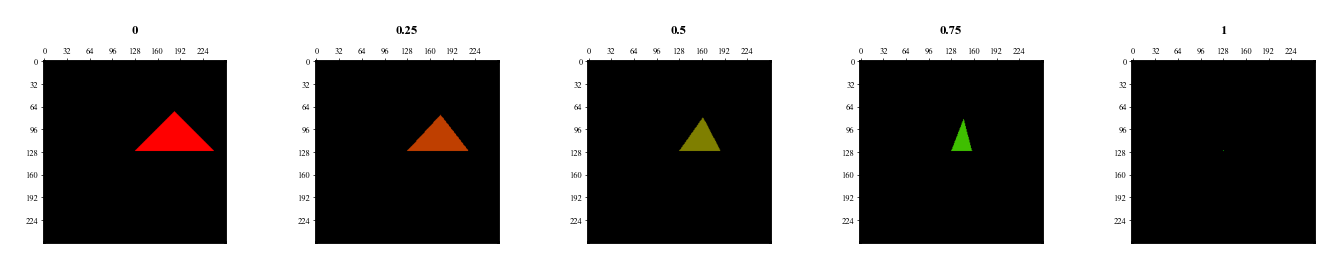

In [17]:
R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 4]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))
# R.setProjM(Ortho(-2, 2, -2, 2, 0.1, 10))

img = []
for i, (rot_mat, clr) in enumerate(zip(interpolated_matrices, interpolated_colors)):
    t = Triangle()
    t.setVertex(0, 0.0, 0.0, 0.0)
    t.setVertex(1, 2.0, 0.0, 0.0)
    t.setVertex(2, 1.0, 1.0, 0.0)
    t.setColor(0, *clr)
    t.setColor(1, *clr)
    t.setColor(2, *clr)
    t.rotate_mat(rot_mat)

    R.clear()
    R.render([t])
    img.append(R.get_rgb_img())

show_images(images=img,
            titles=key_times,
            n=1,
            m=len(key_times),
            font_scale=0.2,
            dpi=256)